In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.6 MB/s eta 0:00:00


In [2]:
# import huggingface datasets: https://huggingface.co/datasets/Matthijs/snacks
from datasets import load_dataset

In [3]:
snacks = load_dataset("Matthijs/snacks")
snacks

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4838
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 952
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 955
    })
})

In [4]:
train_snacks = snacks["train"]
val_snacks = snacks["validation"]
test_snacks = snacks["test"]
train_snacks

Dataset({
    features: ['image', 'label'],
    num_rows: 4838
})

In [5]:
from PIL import Image
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.color import rgb2hsv
import numpy as np

In [6]:
# Feature 1 HOG: processing + HOG descriptor
from skimage.feature import hog
from skimage import color

def pre_and_extract_HOG(imgset):
    # resize to 64 * 128 and to greyscale
    processed_imgset = []
    for i in range(len(imgset)):
        img_array = np.array(color.rgb2gray(imgset[i]["image"]), dtype=np.float32) / 255
        #print("img_array.shape:", img_array.shape)
        img_resized = resize(img_array, (128,64))
        #print("img_resized.shape:", img_resized.shape)
        processed_imgset.append(img_resized)

    fds = []
    hog_images = []
    for i in range(len(processed_imgset)):
        fd, hog_image = hog(processed_imgset[i], orientations=8, \
        pixels_per_cell=(8, 8), cells_per_block=(1, 1), visualize=True)
        fds.append(fd)
        hog_images.append(hog_image)

    return fds, hog_images

In [7]:
# apply on train set and see extracted features shape
fds, hog_images = pre_and_extract_HOG(train_snacks)

In [8]:
# produced output of (4838,1024)
print("Length",len(fds))

Length 4838


In [9]:
# Feature 2: avegrge RGB value
def avg_RGB(imgset):
    avg_RGB = []
    for i in range(len(imgset)):
        image = np.array(imgset[i]["image"],dtype=np.float32) / 255
        label = imgset[i]["label"]
        avg_by_channel = np.mean(image, axis=(0,1))
        avg_RGB.append(avg_by_channel)

    return avg_RGB

In [10]:
avg_RGB_class = avg_RGB(train_snacks)
len(avg_RGB_class)

4838

In [11]:
# Concatenate HOG and average RGB

def concat_HOG_RGB(fds, avg_RGB_class):
    concat_HOG_RGB = []
    for i in range(len(fds)):
        concat_HOG_RGB.append(np.concatenate((fds[i], avg_RGB_class[i]), axis=None))
    return concat_HOG_RGB

concat_HOG_RGB = concat_HOG_RGB(fds, avg_RGB_class)

# dim should be 1024 + 3 = 1027
print("Length",len(concat_HOG_RGB))
print("dim",len(concat_HOG_RGB[0]))


Length 4838
dim 1027


In [12]:
# Apply same on validation and test set
# combine HOG and average RGB

val_fds, val_hog_images = pre_and_extract_HOG(val_snacks)
val_avg_RGB_class = avg_RGB(val_snacks)
val_concat_HOG_RGB = []
for i in range(len(val_fds)):
    val_concat_HOG_RGB.append(np.concatenate((val_fds[i], val_avg_RGB_class[i]), axis=None))

test_fds, test_hog_images = pre_and_extract_HOG(test_snacks)
test_avg_RGB_class = avg_RGB(test_snacks)
test_concat_HOG_RGB = []
for i in range(len(test_fds)):
    test_concat_HOG_RGB.append(np.concatenate((test_fds[i], test_avg_RGB_class[i]), axis=None))

print("Val length",len(val_concat_HOG_RGB))
print("Val dim",len(val_concat_HOG_RGB[0]))
print("Test length",len(test_concat_HOG_RGB))
print("Test dim",len(test_concat_HOG_RGB[0]))

Val length 955
Val dim 1027
Test length 952
Test dim 1027


In [13]:
pip install torchvision

In [14]:
#Feature 3: ResNet50 embeddings
import torchvision.models as models
from torchvision.transforms import ToTensor, Normalize, Compose, Resize

# Load pre-trained ResNet-50
model = models.resnet50(pretrained=True)
layer = model._modules.get('avgpool')
model.eval()  # Set the model to evaluation mode

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 191MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [15]:
# preprocessing steps
# resnet expectes 224 x 224 images
# use ImgNet mean and std to normalize
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models
import torchvision.transforms as Resize
from torch.autograd import Variable

scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

In [16]:
# embeddings function
def get_embedding(img):
    img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0))
    # Resnet 50 avg pool layer expects 2048 x 1 x 1
    embedding = torch.zeros(2048)

    def copy_data(m, i, o):
        embedding.copy_(o.data.squeeze())

    h = layer.register_forward_hook(copy_data)
    model(img)
    h.remove()

    return embedding

In [17]:
# Get train set embeddings
train_embeddings = []
for i in range(len(train_snacks)):
    embedding = get_embedding(train_snacks[i]["image"])
    # flatten and convert to numpy
    train_embeddings.append(embedding.detach().numpy().flatten())

In [18]:
print("Length of train embeddings",len(train_embeddings))
print("Dimension",len(train_embeddings[0]))

Length of train embeddings 4838
Dimension 2048


In [19]:
# Get val and test set embeddings
val_embeddings = []
for i in range(len(val_snacks)):
    embedding = get_embedding(val_snacks[i]["image"])
    val_embeddings.append(embedding.detach().numpy().flatten())
test_embeddings = []
for i in range(len(test_snacks)):
    embedding = get_embedding(test_snacks[i]["image"])
    test_embeddings.append(embedding.detach().numpy().flatten())

print("Length of val embeddings",len(val_embeddings))
print("Dimension",len(val_embeddings[0]))
print("Length of test embeddings",len(test_embeddings))
print("Dimension",len(test_embeddings[0]))

Length of val embeddings 955
Dimension 2048
Length of test embeddings 952
Dimension 2048


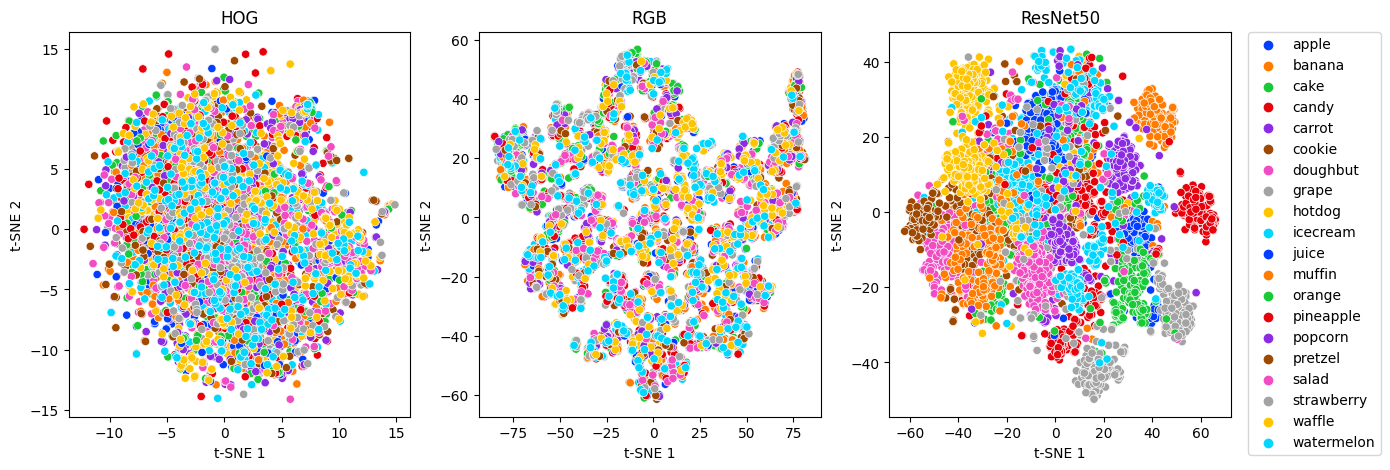

In [50]:
# T-SNE on HOG, RGB, ResNet50 embeddings to visualize effectiveness
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# map label to vocab
label_vocab = {0: "apple",1:"banana",2:"cake",3:"candy",4:"carrot",5:"cookie",6:"doughbut",
7:"grape",8:"hotdog",9:"icecream",10:"juice",11:"muffin",12:"orange",13:"pineapple",14:"popcorn",
15:"pretzel",16:"salad",17:"strawberry",18:"waffle",19:"watermelon"}
mapped_labels = [label_vocab[label] for label in train_snacks["label"]]

# subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].set_title("HOG")
axs[1].set_title("RGB")
axs[2].set_title("ResNet50")

# HOG
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(np.array(fds))
sns.scatterplot(x=X_2d[:,0], y=X_2d[:,1], hue=mapped_labels, ax=axs[0], \
                legend=False,palette='bright')
axs[0].set_xlabel("t-SNE 1")
axs[0].set_ylabel("t-SNE 2")

# RGB
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(np.array(avg_RGB_class))
sns.scatterplot(x=X_2d[:,0], y=X_2d[:,1], hue=mapped_labels, ax=axs[1],\
                legend=False,palette='bright')
axs[1].set_xlabel("t-SNE 1")
axs[1].set_ylabel("t-SNE 2")

# ResNet50
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(np.array(train_embeddings))
sns.scatterplot(x=X_2d[:,0], y=X_2d[:,1], hue=mapped_labels, ax=axs[2],\
                palette='bright')
axs[2].set_xlabel("t-SNE 1")
axs[2].set_ylabel("t-SNE 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

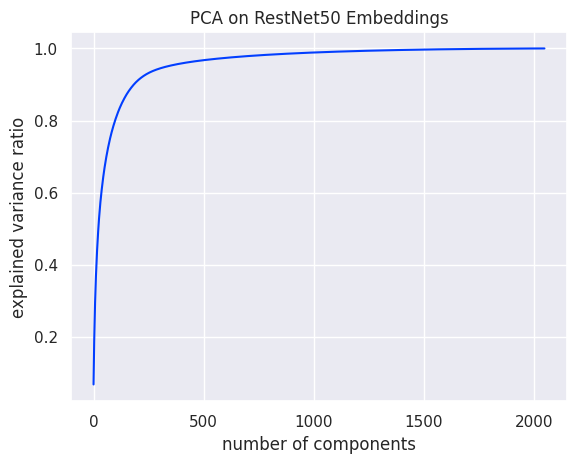

In [52]:
# PCA to reduce dimensions of ResNet embeddings
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA()
train_embed_array = np.array(train_embeddings)
pca.fit(train_embed_array)

# plot PCA
sns.set()
sns.set_palette("bright")
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('explained variance ratio')
plt.title("PCA on RestNet50 Embeddings")
plt.show()


In [21]:
# Based on chart, get the first 1000 components
n_components = 1000
pca = PCA(n_components=n_components)

# Fit PCA on the embeddings and transform them
reduced_embed_train = pca.fit_transform(train_embed_array)
# Do the same for val and test embeddings
reduced_embed_val = pca.transform(np.array(val_embeddings))
reduced_embed_test = pca.transform(np.array(test_embeddings))

In [22]:
len(reduced_embed_val[0])

1000

In [63]:
# Baseline 1: Fit baseline LR on resnet50 + PCA embeddings
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf_LR = LogisticRegression(random_state=0,max_iter=2000).\
fit(reduced_embed_train,train_snacks["label"])

val_pred_LR = clf_LR.predict(reduced_embed_val)
val_acc_LR = accuracy_score(val_snacks["label"], val_pred_LR)
print("Validation accuracy:", val_acc_LR)


Validation accuracy: 0.8094240837696335


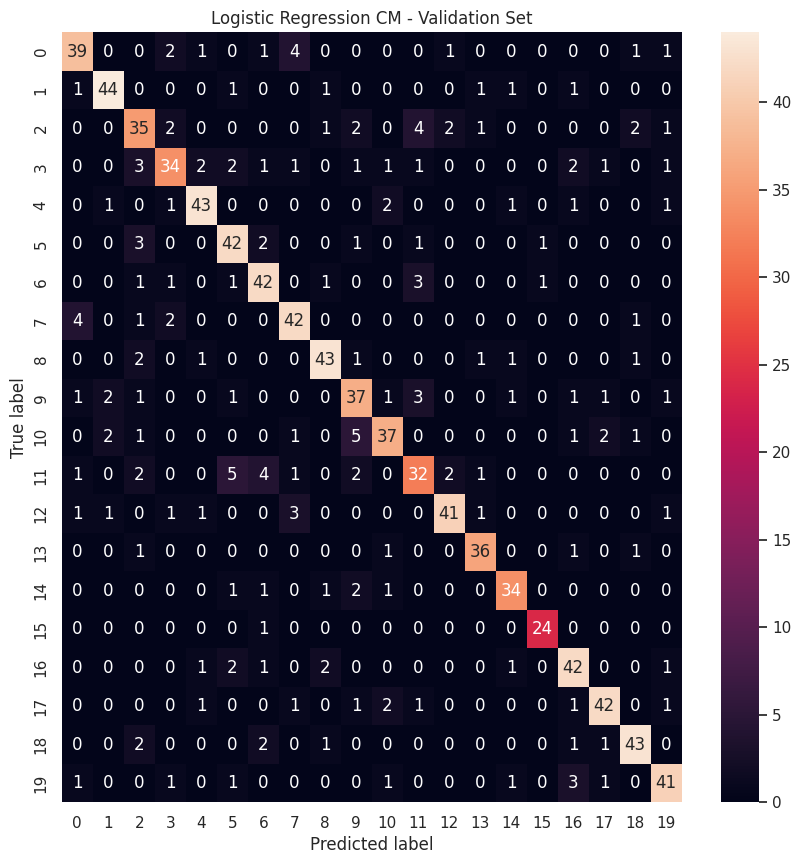

In [64]:
# Confusion matrix for validation set
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm1 = confusion_matrix(val_snacks["label"], val_pred_LR)
plt.figure(figsize=(10,10))
sns.heatmap(cm1, annot=True, fmt=".0f")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Logistic Regression CM - Validation Set")
plt.show()

In [65]:
# Model 2: Fit MLP on resnet50 + PCA embeddings
from sklearn.neural_network import MLPClassifier

clf_MLP = MLPClassifier(random_state=0, max_iter=2000).\
fit(reduced_embed_train,train_snacks["label"])

val_pred_MLP = clf_MLP.predict(reduced_embed_val)
val_acc_MLP = accuracy_score(val_snacks["label"], val_pred_MLP)
print("Validation accuracy:", val_acc_MLP)


Validation accuracy: 0.8303664921465969


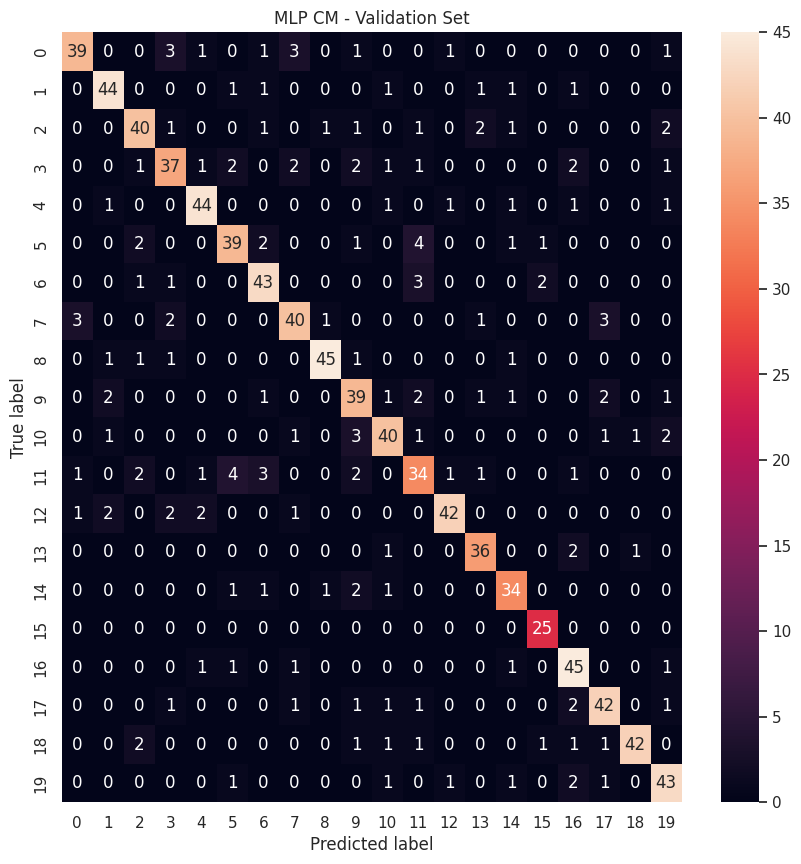

In [66]:
# MLP CM

cm2 = confusion_matrix(val_snacks["label"], val_pred_MLP)
plt.figure(figsize=(10,10))
sns.heatmap(cm2, annot=True, fmt=".0f")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("MLP CM - Validation Set")
plt.show()

In [29]:
# Model 3: Fit SVM on resnet50 + PCA embeddings
from sklearn.svm import SVC

clf_SVM = SVC(random_state=0).\
fit(reduced_embed_train,train_snacks["label"])

val_pred = clf_SVM.predict(reduced_embed_val)
val_acc = accuracy_score(val_snacks["label"], val_pred)
print("Validation accuracy:", val_acc)

Validation accuracy: 0.8345549738219895


In [35]:
# Do a grid search on SVM
from sklearn.model_selection import GridSearchCV

parameters = {'C': [0.1, 1, 10]}
svc = SVC(random_state=0)
clf = GridSearchCV(svc, parameters)
clf.fit(reduced_embed_train,train_snacks["label"])

print(clf.best_params_)

{'C': 10}


In [67]:
# Best parameter model
clf_SVM = SVC(random_state=0, C=10).\
fit(reduced_embed_train,train_snacks["label"])

val_pred_SVM = clf_SVM.predict(reduced_embed_val)
val_acc_SVM = accuracy_score(val_snacks["label"], val_pred_SVM)
print("Validation accuracy:", val_acc_SVM)

Validation accuracy: 0.8387434554973822


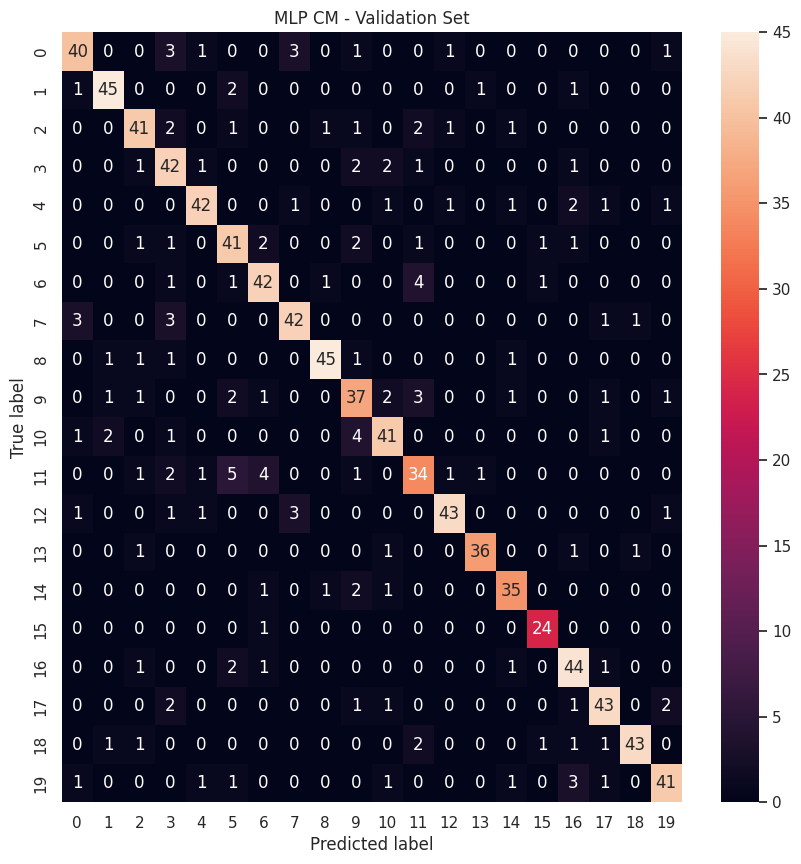

In [68]:
# SVM CM

cm3 = confusion_matrix(val_snacks["label"], val_pred_SVM)
plt.figure(figsize=(10,10))
sns.heatmap(cm3, annot=True, fmt=".0f")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("MLP CM - Validation Set")
plt.show()

In [71]:
# Evaluate on test set

# LR
test_pred = clf_LR.predict(reduced_embed_test)
test_acc = accuracy_score(test_snacks["label"], test_pred)
print("LR Test accuracy:", test_acc)

# MLP
test_pred = clf_MLP.predict(reduced_embed_test)
test_acc = accuracy_score(test_snacks["label"], test_pred)
print("MLP Test accuracy:", test_acc)

# SVM
test_pred = clf_SVM.predict(reduced_embed_test)
test_acc = accuracy_score(test_snacks["label"], test_pred)
print("SVM Test accuracy:", test_acc)

LR Test accuracy: 0.8224789915966386
MLP Test accuracy: 0.8466386554621849
SVM Test accuracy: 0.8413865546218487
